# Working with EDI files and MTpy

This notebook shows how to load MT data from EDI files with [MTpy](https://github.com/MTgeophysics/mtpy) and convert EDI files into GoFEM inversion input.

Additionally, it shows how to use topography and coastline data and convert them from geographic to local rectangulat coordinates.

To run this notebook, along with MTpy you need to also have [cartopy](https://scitools.org.uk/cartopy/docs/latest/), [shapely](https://shapely.readthedocs.io/en/latest/project.html) and [geopandas](https://geopandas.org/) packages installed. All the packages can be installed via `conda install`

*Created by A. Grayver, 2020*

Let us start by including required python packages


In [1]:
import os
import sys
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
import shapely
import cartopy.crs as ccrs

from shapely.geometry import Polygon, MultiPolygon, Point
from scipy.interpolate import RegularGridInterpolator
from netCDF4 import Dataset

%matplotlib inline

Next, let the python know where MTpy's python package lives and also include pyGoFEM tools:

In [2]:
# MTpy
sys.path.insert(0,'/home/agrayver/Documents/Progs/mtpy')
from mtpy.core.mt import MT
from mtpy.core.edi_collection import EdiCollection
from mtpy.utils.shapefiles_creator import ShapefilesCreator, plot_phase_tensor_ellipses_and_tippers
from mtpy.imaging.plotnresponses import PlotMultipleResponses

# GoFEM
module_path = os.path.abspath('../')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from gofem.parameter_handler import *
from gofem.mesh_utils import *
from gofem.mtpy_utils import *

## Reading data

Read EDI files

In [3]:
edi_path = "./EDI/"
edi_files = glob.glob(os.path.normpath(os.path.abspath(os.path.join(edi_path, "*.edi"))))
edi_collection = EdiCollection(edi_files)

INFO:mtpy.core.edi_collection:number of edi files in this collection: 41


number of stations/edifiles = 41


INFO:mtpy.core.edi_collection:Number of MT Periods: 41
/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,StationId,Lon,Lat,Elev,UtmZone,geometry
0,M37,38.758608,7.739719,0.0,37N,POINT (38.75861 7.73972)
1,M18_1,38.795056,7.732567,0.0,37N,POINT (38.79506 7.73257)
2,M24,38.804139,7.825581,0.0,37N,POINT (38.80414 7.82558)
3,M19,38.815917,7.778597,0.0,37N,POINT (38.81592 7.77860)
4,M38,38.749392,7.739453,0.0,37N,POINT (38.74939 7.73945)
5,M34,38.776842,7.732767,0.0,37N,POINT (38.77684 7.73277)
6,M10,38.818497,7.787614,0.0,37N,POINT (38.81850 7.78761)
7,M13,38.811289,7.757828,0.0,37N,POINT (38.81129 7.75783)
8,M31,38.771797,7.816817,0.0,37N,POINT (38.77180 7.81682)
9,M22,38.800931,7.808917,0.0,37N,POINT (38.80093 7.80892)


For the sake of demonstration, let us interpolate data to a common frequency layout. There is no particular purpose to do this here, but this operation os often required with real data and it is good to know how to do this efficiently.

In [4]:
# period list to interpolate onto
period_list = np.logspace(-2, 3, 21)

save_path = "./EDI_interpolated/"

for p in glob.iglob(os.path.join(save_path, '*.edi')):
    os.remove(p)

edi_collection.export_edi_files(save_path, 
                                period_list=period_list, # if not provided, will search edi files and find
                                                         # periods present in at least 10% of edis
                                period_buffer=2 # factor to stretch interpolation by. For example: if period_buffer=2
                                                # then interpolated data points will only be included if they are
                                                # within a factor of 2 of a true data point.
                                )

/home/agrayver/Documents/Progs/mtpy/mtpy/utils/calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


Read in interpolated data again:

In [5]:
edi_path = "./EDI_interpolated/"
edi_files = glob.glob(os.path.normpath(os.path.abspath(os.path.join(edi_path, "*.edi"))))
edi_collection = EdiCollection(edi_files)

INFO:mtpy.core.edi_collection:number of edi files in this collection: 41


number of stations/edifiles = 41


INFO:mtpy.core.edi_collection:Number of MT Periods: 21


Create a geopandas data frame storing geometrical information about all stations:

In [8]:
gdf = edi_collection.create_mt_station_gdf()
gdf

/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,StationId,Lon,Lat,Elev,UtmZone,geometry
0,M25,38.804558,7.834908,0.0,37N,POINT (38.80456 7.83491)
1,M34,38.776842,7.732767,0.0,37N,POINT (38.77684 7.73277)
2,M17,38.785881,7.742881,0.0,37N,POINT (38.78588 7.74288)
3,M20,38.760439,7.800567,0.0,37N,POINT (38.76044 7.80057)
4,M27,38.764367,7.784131,0.0,37N,POINT (38.76437 7.78413)
5,M26,38.774139,7.784194,0.0,37N,POINT (38.77414 7.78419)
6,M38,38.749392,7.739453,0.0,37N,POINT (38.74939 7.73945)
7,M31,38.771797,7.816817,0.0,37N,POINT (38.77180 7.81682)
8,M29,38.751792,7.815769,0.0,37N,POINT (38.75179 7.81577)
9,M24,38.804139,7.825581,0.0,37N,POINT (38.80414 7.82558)


It is easy to inspect individual stations. E.g., we can retrieve a station by its name:

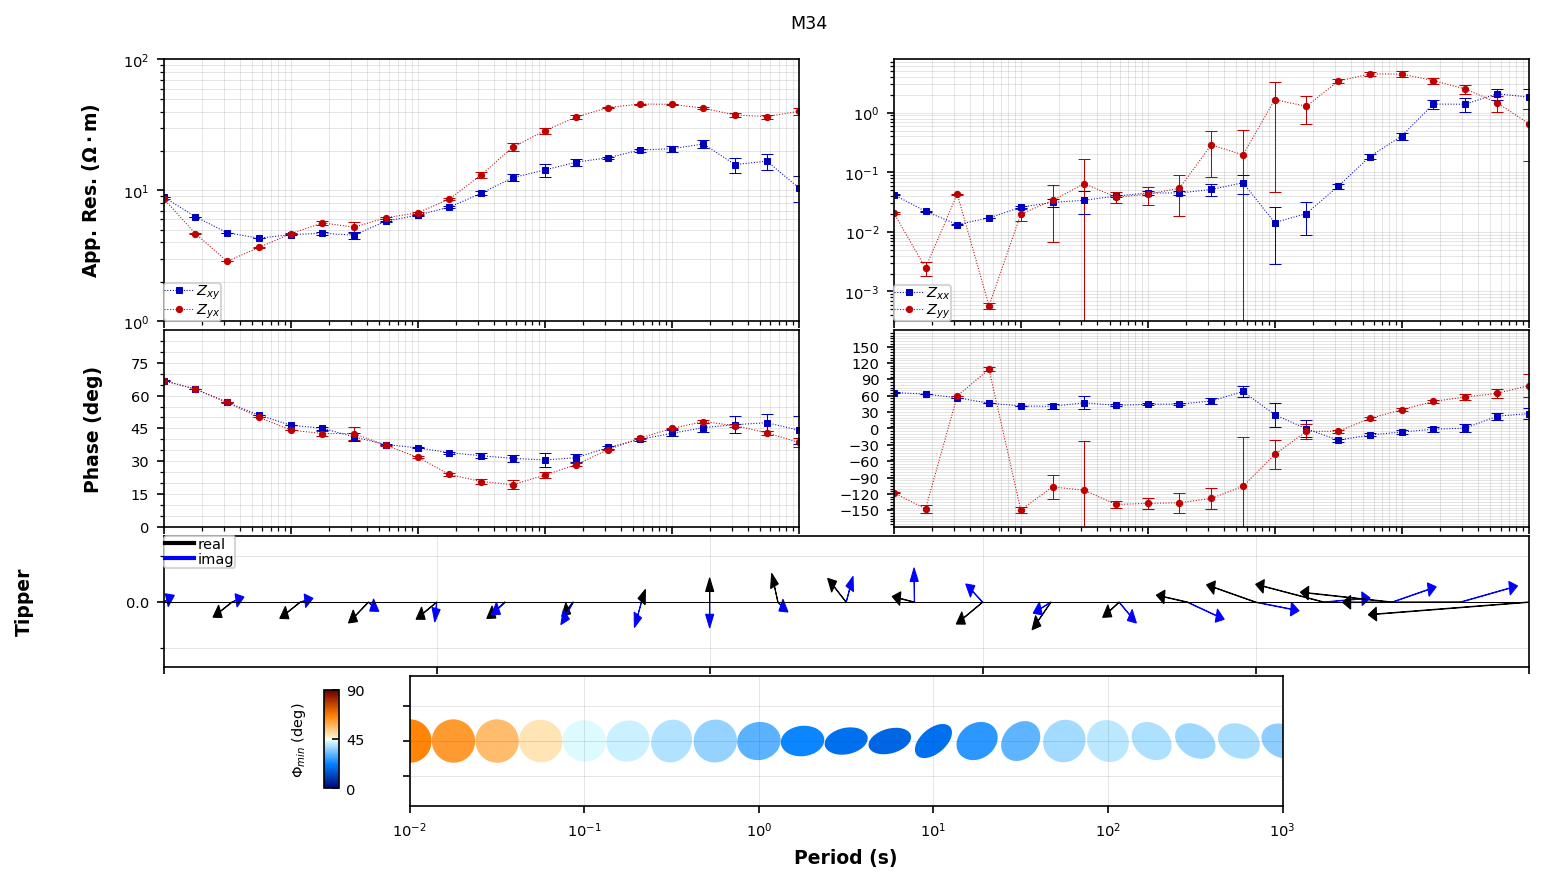

In [6]:
gdf = edi_collection.create_mt_station_gdf()

station = 'M34'
sindex = gdf.index[gdf['StationId'] == station][0]

plot_obj = edi_collection.mt_obj_list[sindex].plot_mt_response(plot_num = 2, ploy_yn = 'y')

It is also useful to be able to inspect data in a map view. To this end, let us first convert EDI objects into appropriate map objects:

In [7]:
shpobj = ShapefilesCreator(edi_files, './EDI')

period = 10
gdf_PT, _ = shpobj.create_phase_tensor_shp(period)
gdf_reT, _ = shpobj.create_tipper_real_shp(period)
gdf_imT, _ = shpobj.create_tipper_imag_shp(period)

INFO:mtpy.core.edi_collection:number of edi files in this collection: 41


number of stations/edifiles = 41


INFO:mtpy.core.edi_collection:Number of MT Periods: 21
INFO:mtpy.core.edi_collection:1,2,3,4 5 Percentile distances: 0.00799083717633412, 0.008921105685916598, 0.009770482469291278, 0.010593271676828605, 0.011191440417459708


count    820.000000
mean       0.049657
std        0.023933
min        0.004054
25%        0.030370
50%        0.049611
75%        0.067736
max        0.114161
dtype: float64
The plot period is  10


INFO:mtpy.core.edi_collection:Saved shapefile to ./EDI/Period_10/Phase_Tensor_EPSG_4283_Period_10.shp
INFO:mtpy.core.edi_collection:Automatically Selected Max Tipper Length  = 0.00799083717633412
/home/agrayver/Documents/Progs/mtpy/mtpy/utils/calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


The plot period is  10


/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
INFO:mtpy.core.edi_collection:Saved shapefile to ./EDI/Period_10/Tipper_Real_EPSG_4283_Period_10.shp
INFO:mtpy.core.edi_collection:Automatically Selected Max-Tipper Length =: 0.00799083717633412
/home/agrayver/Documents/Progs/mtpy/mtpy/utils/calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


The plot period is  10


/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
INFO:mtpy.core.edi_collection:Saved shapefile to ./EDI/Period_10/Tipper_Imag_EPSG_4283_Period_10.shp


Read ETOPO data and extract relevant part covering our survey area:

In [9]:
nc_f = Dataset('./data/ETOPO1_Ice_c_gmt4.grd', 'r')

lon_etopo = np.array(nc_f.variables['x'][:])
lat_etopo = np.array(nc_f.variables['y'][:])
z_etopo = nc_f.variables['z'][:]

bbox = edi_collection.bound_box_dict

model_extent = [bbox['MinLon']-0.1, bbox['MaxLon']+0.1, bbox['MinLat']-0.1, bbox['MaxLat']+0.1]
lon_idx = np.where((lon_etopo > model_extent[0]) & (lon_etopo < model_extent[1]))[0]
lat_idx = np.where((lat_etopo > model_extent[2]) & (lat_etopo < model_extent[3]))[0]

lon_etopo = lon_etopo[lon_idx]
lat_etopo = lat_etopo[lat_idx]

lon_grid, lat_grid = np.meshgrid(lon_etopo, lat_etopo, sparse=False, indexing='xy')

z_etopo = z_etopo[np.ix_(lat_idx, lon_idx)]

Plot stations:

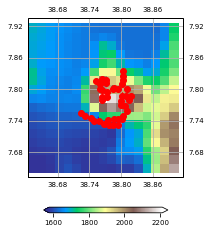

In [17]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(model_extent)
gl = ax.gridlines(draw_labels=True)

terrain_map = colors.LinearSegmentedColormap.from_list('terrain_map',
    all_colors)

pcm = ax.pcolormesh(lon_etopo, lat_etopo, z_etopo, cmap = 'terrain')

cbar = fig.colorbar(pcm, ax = ax, extend='both', shrink=0.8, pad = 0.05, orientation='horizontal')

ax.add_geometries(gdf_PT['geometry'], ccrs.PlateCarree(), facecolor='none',
                  edgecolor='black', zorder = 2)

ax.add_geometries(gdf_reT['tip_re'], ccrs.PlateCarree(),
                  edgecolor='b', zorder = 2)

ax.add_geometries(gdf_imT['tip_im'], ccrs.PlateCarree(),
                  edgecolor='r', zorder = 2)

ax.scatter(gdf['Lon'], gdf['Lat'], marker = 'o', color = 'r', zorder = 3)

#ax.set_aspect('equal', adjustable=None)

Convert all coordinates to the local rectangular frame centered at the survey. Remember we use coordinate system where Z points down, X points to the North and Y points to the East.

In [20]:
crs = ccrs.UTM(37, southern_hemisphere=False)
[x0, y0] = crs.transform_point((bbox['MinLon']+bbox['MaxLon']) / 2.,
                               (bbox['MinLat']+bbox['MaxLat']) / 2., ccrs.Geodetic())

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
gdf_cartesian = gdf.to_crs(crs_proj4)

x_st = []
y_st = []
[[y_st.append(p.x - x0), x_st.append(p.y - y0)] for p in gdf_cartesian['geometry']]
            
etopo_cart = crs.transform_points(ccrs.Geodetic(), lon_grid, lat_grid, z_etopo)

etopo_cart[:,:,0] -= x0
etopo_cart[:,:,1] -= y0

Plot evetything in the Cartesian frame:

(-10000.0, 10000.0)

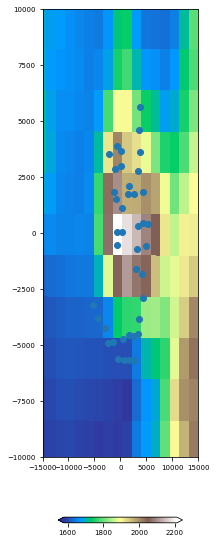

In [24]:
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()

pcm = ax.pcolormesh(etopo_cart[:,:,0], etopo_cart[:,:,1], etopo_cart[:,:,2],\
                    cmap = 'terrain')

cbar = fig.colorbar(pcm, ax = ax, extend='both', shrink=0.8, pad = 0.1, orientation='horizontal')
    
ax.scatter(y_st, x_st, marker = 'o')

ax.set_xlim([-1.5e4, 1.5e4])
ax.set_ylim([-1e4, 1e4])

## Create GoFEM input files

Create receiver and frequency files that are necessary to run GoFEM:

In [ ]:
with open('./gofem/receivers.csv', 'w') as f:
    f.write('# type name n_electrodes x y z\n')
    for n, name in enumerate(gdf_cartesian['StationId']):
        f.write("Dipole %s 1 %0.6e %0.6e %0.6e\n" % (name, x_st[n], y_st[n], 0.1))
        
frequencies = np.reciprocal(period_list)
np.savetxt('./gofem/frequencies', frequencies, header = '# frequency (Hz)')

Create a data file. Try `help(write_edi_collection_to_gofem)` to get more information about this function.

In [ ]:
write_edi_collection_to_gofem(edi_interpolated,\
                              outfile = './gofem/invdata.dat',\
                              error_floor = 0.05,\
                              data_type = 'Z')

Specify a free parameter box. All cells within this box will be treated as free parameters in inversion. All cells outside this box remain fixed.

In [26]:
point_begin = [-25000, -25000, 0]
point_end = [25000, 25000, 50000]

Finally, we need a parameter file:

In [ ]:
prm = ParameterHandler(inversion = True, dim = 3)

# Let's use linear elements
prm.setitem(section = 'Modeling',\
            parameter = 'Order',\
            value = 1)
# Let's refine cells around receivers for further accuracy
prm.setitem(section = 'Modeling',\
            parameter = 'Refine cells around receivers',\
            value = 2)
# Set 2D boundary conditions
prm.setitem(section = 'Modeling',\
            parameter = 'BC',\
            value = 'Dirichlet2D')
# Let's calculate all frequencies in parallel
prm.setitem(section = 'Modeling',\
            parameter = 'Number of parallel frequencies',\
            value = len(frequencies))

# Solver options
prm.setitem(section = 'Solver',\
            parameter = 'Preconditioner',\
            value = 'Direct')

# Tell the code where to read all files from
prm.setitem(section = 'Model',\
            parameter = 'Model definition file',\
            value = '../model.tria')
prm.setitem(section = 'Model',\
            parameter = 'Materials definition file',\
            value = '../model.materials')
prm.setitem(section = 'Model',\
            parameter = 'Inversion model definition file',\
            value = '../model.tria')
prm.setitem(section = 'Model',\
            parameter = 'Inversion materials definition file',\
            value = '../model.materials')
prm.setitem(section = 'Model',\
            parameter = 'Active domain mask',\
            value = '../model.mask')
prm.setitem(section = 'Model',\
            parameter = 'Active domain box',\
            value = point_begin + point_end)

prm.setitem(section = 'Survey',\
            parameter = 'Frequencies file',
            value = '../frequencies')
prm.setitem(section = 'Survey',\
            parameter = 'Stations file',
            value = '../receivers.csv')

# Output parameters
prm.setitem(section = 'Output',\
            parameter = 'Type',
            value = 'point,volume')
prm.setitem(section = 'Output',\
            parameter = 'Data file',
            value = 'model')
prm.setitem(section = 'Output',\
            parameter = 'Parallel output',
            value = 'false')

# Inversion parameters
prm.setitem(section = 'Inversion',\
            parameter = 'Inversion input data',
            value = '../invdata.dat')
prm.setitem(section = 'Inversion',\
            parameter = 'Scaling factor',
            value = [0.01,])
prm.setitem(section = 'Inversion',\
            parameter = 'Regularization update',
            value = 100)
prm.setitem(section = 'Inversion',\
            parameter = 'Output files prefix',
            value = 'vic')

# Finally, write down the parameter file
prm.write('./gofem/input.prm')